In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
import math
import cv2

import os
import shutil

%matplotlib inline

# Download, Split and Transform our Data

After downloading the data, split the training data into a training and validation set. Then create DataLoaders for each of these sets of data.

In [43]:
os.environ['KAGGLE_USERNAME'] = "###" # username from the json file
os.environ['KAGGLE_KEY'] = "###" # key from the json file
!kaggle datasets download -d ma7555/cat-breeds-dataset


cat-breeds-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

home_dir = os.getcwd()

if os.path.exists(os.path.join(home_dir, 'cats')):
  shutil.rmtree(os.path.join(home_dir, 'cats'))

local_zip = '/content/cat-breeds-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/cats')
zip_ref.close()

In [45]:
# get the number of breeds saved as folders in the image dataset
num_breed_folders = len(os.listdir(os.path.join(home_dir, 'cats/images')))
num_breed_folders

67

In [46]:
# inspect CSV data
cats_df = pd.read_csv(os.path.join(home_dir, 'cats/data/cats.csv'))
# remove 'Unnamed: 0' column
cats_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cats_df.head()

,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,46744842,https://www.petfinder.com/cat/arianna-46744842...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh...,Cat,Adult,Male,Extra Large,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
2,46626338,https://www.petfinder.com/cat/zena-46626338/ca...,Cat,Senior,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
3,46620170,https://www.petfinder.com/cat/mika-46620170/ca...,Cat,Baby,Female,Small,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl...,Cat,Young,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...


In [47]:
# get the total number of image files
num_images = sum(len(f) for r, d, f in os.walk(os.path.join(home_dir, 'cats/images')))
num_images

126607

In [48]:
num_images_list = []
breed_list = []
# check the total number of images 
for i, (r, d, f) in enumerate(os.walk(os.path.join(home_dir, 'cats/images'))):
  if i == 0:
    continue
  breed = r.split('/')[-1]
  num_images_list.append(len(f))
  breed_list.append(breed)


# create dataframe of breeds and their respective counts
count_df = pd.DataFrame(list(zip(breed_list, num_images_list)), columns=['Breed', 'Count'])
count_df.head()

,Breed,Count
0,Bengal,2477
1,Russian Blue,1870
2,American Curl,149
3,Maine Coon,1418
4,Bombay,1835


In [49]:
count_df.describe()

,Count
count,67.000000
mean,1889.656716
std,6508.437984
min,1.000000
25%,106.000000
50%,260.000000
75%,1964.500000
max,53027.000000


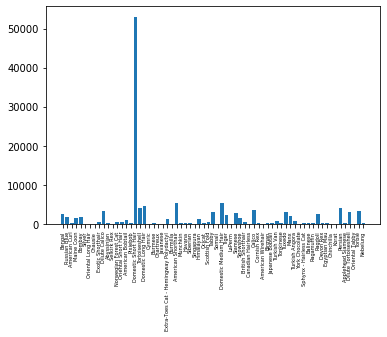

In [50]:
index = count_df.Breed
plt.bar(index, count_df.Count)
plt.xticks(index, fontsize=5, rotation=90)
plt.show()

In [0]:
img_width, img_height = 224, 224

# number of epochs to train top model
epochs = 20

# batch size used by flow_from_directory and predict_generator
batch_size = 20

# Remove classes
Remove classes that have image quantities less than the 25th percentile or more than the 65th percentile.

In [52]:
train_breeds_list = []

for i in range(len(count_df)):
  if count_df.iloc[i, 1] < 2000 and count_df.iloc[i, 1] > 200:
    train_breeds_list.append((count_df.iloc[i, 0], count_df.iloc[i, 1]))

print(train_breeds_list)

train_breeds_df = pd.DataFrame(data=train_breeds_list, columns=['Breed', 'Count'])

train_breeds_df['Count'].mean()

[('Russian Blue', 1870), ('Maine Coon', 1418), ('Bombay', 1835), ('Exotic Shorthair', 471), ('Abyssinian', 255), ('Norwegian Forest Cat', 580), ('Oriental Short Hair', 491), ('American Bobtail', 991), ('Burmese', 344), ('Extra-Toes Cat - Hemingway Polydactyl', 1184), ('Himalayan', 1301), ('Scottish Fold', 380), ('Snowshoe', 1625), ('British Shorthair', 567), ('Birman', 227), ('Turkish Van', 815), ('Tonkinese', 260), ('Turkish Angora', 750), ('Sphynx - Hairless Cat', 209), ('Balinese', 254), ('Egyptian Mau', 305)]


768.1904761904761

In [53]:
# inspect the dataframe
train_breeds_df.describe()

,Count
count,21.000000
mean,768.190476
std,556.561373
min,209.000000
25%,305.000000
50%,567.000000
75%,1184.000000
max,1870.000000


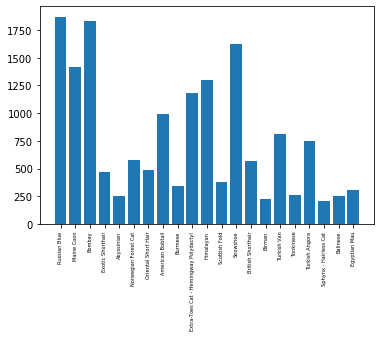

In [54]:
plt.bar(train_breeds_df['Breed'], train_breeds_df['Count'])
plt.xticks(train_breeds_df['Breed'], fontsize=5, rotation=90)
plt.show()

In [55]:
train_breeds_df.select_dtypes(include=['object']).describe()

,Breed
count,21
unique,21
top,Abyssinian
freq,1


In [56]:
train_breeds_df['Breed']

0                              Russian Blue
1                                Maine Coon
2                                    Bombay
3                          Exotic Shorthair
4                                Abyssinian
5                      Norwegian Forest Cat
6                       Oriental Short Hair
7                          American Bobtail
8                                   Burmese
9     Extra-Toes Cat - Hemingway Polydactyl
10                                Himalayan
11                            Scottish Fold
12                                 Snowshoe
13                        British Shorthair
14                                   Birman
15                              Turkish Van
16                                Tonkinese
17                           Turkish Angora
18                    Sphynx - Hairless Cat
19                                 Balinese
20                             Egyptian Mau
Name: Breed, dtype: object

## Minority class upsampling

The spread of the data in terms of image quantities is better than before. However we still cannot ignore the obvious imbalances as the values range from about 200 to 1900. 

To handle this, we artificially create copies of the images, with some augmentation, in classes that represent the 50th percentile and below.



In [0]:
perc_25_list = train_breeds_df[train_breeds_df['Count'] <= 305].Breed
perc_50_list = train_breeds_df[(train_breeds_df['Count'] > 305) & (train_breeds_df['Count'] <= 567)].Breed
perc_65_list = train_breeds_df[(train_breeds_df['Count'] > 567) & (train_breeds_df['Count'] <= 800)].Breed

In [58]:
print(perc_25_list)
print(perc_50_list)
print(perc_65_list)

4                Abyssinian
14                   Birman
16                Tonkinese
18    Sphynx - Hairless Cat
19                 Balinese
20             Egyptian Mau
Name: Breed, dtype: object
3        Exotic Shorthair
6     Oriental Short Hair
8                 Burmese
11          Scottish Fold
13      British Shorthair
Name: Breed, dtype: object
5     Norwegian Forest Cat
17          Turkish Angora
Name: Breed, dtype: object


Copy and augment images from 25th percentile 2 times, 1 time for those between the 25th and 50th percentile, and 1 time for those between the 50th and 65th percentile.

In [0]:
from PIL import Image
from PIL import ImageFilter

if os.path.exists(os.path.join(home_dir, 'cats_data')):
  shutil.rmtree(os.path.join(home_dir, 'cats_data'))

# make directories for train, val and test
root_dir = os.path.join(home_dir, 'cats_data')
os.makedirs(root_dir)

# make train, val and test dirs
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')

os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(test_dir)

# make folders representing each breed in each train and test dir
for label in train_breeds_df['Breed'].unique():
  os.makedirs(os.path.join(train_dir, label))
  os.makedirs(os.path.join(validation_dir, label))
  os.makedirs(os.path.join(test_dir, label))

Number of images in Abyssinian folder: 1530
Number of images in Abyssinian folder: 2805
Number of images in Birman folder: 1362
Number of images in Birman folder: 2497
Number of images in Tonkinese folder: 1560
Number of images in Tonkinese folder: 2860
Number of images in Sphynx - Hairless Cat folder: 1254
Number of images in Sphynx - Hairless Cat folder: 2299
Number of images in Balinese folder: 1524
Number of images in Balinese folder: 2794
Number of images in Egyptian Mau folder: 1830
Number of images in Egyptian Mau folder: 3355
Number of images in Exotic Shorthair folder: 2826
Number of images in Oriental Short Hair folder: 2946
Number of images in Burmese folder: 2064
Number of images in Scottish Fold folder: 2280
Number of images in British Shorthair folder: 3402
Number of images in Norwegian Forest Cat folder: 3480
Number of images in Turkish Angora folder: 4500


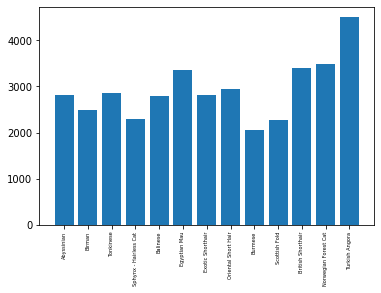

In [60]:
num_images_list = []

# for 25th percentile and below
for breed in perc_25_list:
  folder_dir = os.path.join(home_dir, f'cats/images/{breed}')
  filelist = os.listdir(folder_dir)
  for count in range(0, 2):
    for imagefile in filelist:
      file_dir = os.path.join(folder_dir, imagefile)
      img = Image.open(file_dir)
      img = img.convert("RGB")
      r, g, b = img.split()

      r = r.convert("RGB")
      g = g.convert("RGB")
      b = b.convert("RGB")
      img_blur = img.filter(ImageFilter.GaussianBlur)
      img_unsharp = img.filter(ImageFilter.UnsharpMask)
      
      r.save(os.path.join(folder_dir, (str(count) + 'r_' + imagefile)))
      g.save(os.path.join(folder_dir, (str(count) + 'g_' + imagefile)))
      b.save(os.path.join(folder_dir, (str(count) + 'b_' + imagefile)))
      img_blur.save(os.path.join(folder_dir, (str(count) + 'blur_' + imagefile)))
      img_unsharp.save(os.path.join(folder_dir, (str(count) + 'un_' + imagefile)))

    num_images = len(os.listdir(folder_dir))
    print(f"Number of images in {breed} folder: {num_images}")

  num_images_list.append((breed, num_images))



# for 25th-50th percentile
for breed in perc_50_list:
  folder_dir = os.path.join(home_dir, f'cats/images/{breed}')
  filelist = os.listdir(folder_dir)
  for count in range(0, 1):
    for imagefile in filelist:
      file_dir = os.path.join(folder_dir, imagefile)
      img = Image.open(file_dir)
      img = img.convert("RGB")
      r, g, b = img.split()

      r = r.convert("RGB")
      g = g.convert("RGB")
      b = b.convert("RGB")
      img_blur = img.filter(ImageFilter.GaussianBlur)
      img_unsharp = img.filter(ImageFilter.UnsharpMask)

      r.save(os.path.join(folder_dir, (str(count) + 'r_' + imagefile)))
      g.save(os.path.join(folder_dir, (str(count) + 'g_' + imagefile)))
      b.save(os.path.join(folder_dir, (str(count) + 'b_' + imagefile)))
      img_blur.save(os.path.join(folder_dir, (str(count) + 'blur_' + imagefile)))
      img_unsharp.save(os.path.join(folder_dir, (str(count) + 'un_' + imagefile)))

    num_images = len(os.listdir(folder_dir))
    print(f"Number of images in {breed} folder: {num_images}")

  num_images_list.append((breed, num_images))


# for 50th-65th percentile
for breed in perc_65_list:
  folder_dir = os.path.join(home_dir, f'cats/images/{breed}')
  filelist = os.listdir(folder_dir)
  for count in range(0, 1):
    for imagefile in filelist:
      file_dir = os.path.join(folder_dir, imagefile)
      img = Image.open(file_dir)
      img = img.convert("RGB")
      r, g, b = img.split()

      r = r.convert("RGB")
      g = g.convert("RGB")
      b = b.convert("RGB")
      img_blur = img.filter(ImageFilter.GaussianBlur)
      img_unsharp = img.filter(ImageFilter.UnsharpMask)

      r.save(os.path.join(folder_dir, (str(count) + 'r_' + imagefile)))
      g.save(os.path.join(folder_dir, (str(count) + 'g_' + imagefile)))
      b.save(os.path.join(folder_dir, (str(count) + 'b_' + imagefile)))
      img_blur.save(os.path.join(folder_dir, (str(count) + 'blur_' + imagefile)))
      img_unsharp.save(os.path.join(folder_dir, (str(count) + 'un_' + imagefile)))

    num_images = len(os.listdir(folder_dir))
    print(f"Number of images in {breed} folder: {num_images}")

  num_images_list.append((breed, num_images))



count_df = pd.DataFrame(data=num_images_list, columns=['Breed', 'Count'])

plt.bar(count_df['Breed'], count_df['Count'])
plt.xticks(count_df['Breed'], fontsize=5, rotation=90)
plt.show()

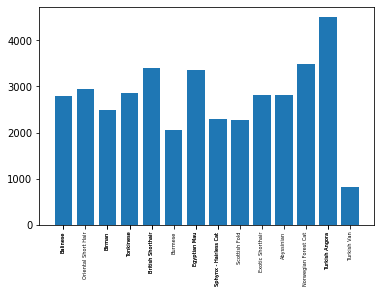

In [61]:
train_breeds_df = train_breeds_df.sort_values(by=['Breed'])
count_df = count_df.sort_values(by=['Breed'])

train_breeds_df.update(count_df)

plt.bar(train_breeds_df['Breed'], train_breeds_df['Count'])
plt.xticks(train_breeds_df['Breed'], fontsize=5, rotation=90)
plt.show()

# Split Data into Train, Validation and Test Folders

In [0]:
if os.path.exists(os.path.join(home_dir, 'cats_data')):
  shutil.rmtree(os.path.join(home_dir, 'cats_data'))

# make directories for train, val and test
root_dir = os.path.join(home_dir, 'cats_data')
os.makedirs(root_dir)

# make train, val and test dirs
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')

os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(test_dir)

# make folders representing each breed in each train and test dir
for breed in train_breeds_df['Breed'].unique():
  os.makedirs(os.path.join(train_dir, breed))
  os.makedirs(os.path.join(validation_dir, breed))
  os.makedirs(os.path.join(test_dir, breed))

In [63]:
np.random.seed(42)

for i, (r, d, f) in enumerate(os.walk(os.path.join(home_dir, 'cats/images'))):
  label = r.split('/')[-1]

  if i == 0:
    continue

  for breed in train_breeds_df['Breed']:
    if label == breed:
      filenames = f
      # shuffle filenames
      np.random.shuffle(filenames)
      # train on a smaller portion of the dataset (hardware concerns)
      file_length = len(filenames)

      train_file_length = int(file_length * 0.7)
      validation_file_length = int(file_length * 0.2)
      test_file_length = int(file_length * 0.1)
      
      filenames_array = np.array(filenames)
      train_files= filenames_array[:train_file_length]
      validation_files = filenames_array[train_file_length: (train_file_length + validation_file_length)]
      test_files= filenames_array[(train_file_length + validation_file_length):(train_file_length + validation_file_length + test_file_length)]

      # get the full path of each image in the train and test splits
      train_filename_list = []
      validation_filename_list = []
      test_filename_list = []

      for filename in train_files:
        train_filename_list.append(os.path.join(home_dir, f'cats/images/{label}/{filename}'))
      for filename in validation_files:
        validation_filename_list.append(os.path.join(home_dir, f'cats/images/{label}/{filename}'))
      for filename in test_files:
        test_filename_list.append(os.path.join(home_dir, f'cats/images/{label}/{filename}'))

      # copy into cats_data folder
      print(f"Copying {len(train_filename_list)} images into {label}'s' train folder...")
      for name in train_filename_list:
        shutil.copy(name, os.path.join(home_dir, f'cats_data/train/{label}'))

      print(f"Copying {len(validation_filename_list)} images into {label}'s' validation folder...")
      for name in validation_filename_list:
        shutil.copy(name, os.path.join(home_dir, f'cats_data/validation/{label}'))

      print(f"Copying {len(test_filename_list)} images into {label}'s' test folder...")
      for name in test_filename_list:
        shutil.copy(name, os.path.join(home_dir, f'cats_data/test/{label}'))

    else:
      continue

Copying 1978 images into Exotic Shorthair's' train folder...
Copying 565 images into Exotic Shorthair's' validation folder...
Copying 282 images into Exotic Shorthair's' test folder...
Copying 1963 images into Abyssinian's' train folder...
Copying 561 images into Abyssinian's' validation folder...
Copying 280 images into Abyssinian's' test folder...
Copying 2436 images into Norwegian Forest Cat's' train folder...
Copying 696 images into Norwegian Forest Cat's' validation folder...
Copying 348 images into Norwegian Forest Cat's' test folder...
Copying 2062 images into Oriental Short Hair's' train folder...
Copying 589 images into Oriental Short Hair's' validation folder...
Copying 294 images into Oriental Short Hair's' test folder...
Copying 1444 images into Burmese's' train folder...
Copying 412 images into Burmese's' validation folder...
Copying 206 images into Burmese's' test folder...
Copying 1596 images into Scottish Fold's' train folder...
Copying 456 images into Scottish Fold's' 

# Improving the Model (Image Augmentation)
We will augment the images to provide more samples for the model to train on.

Augmentation simply changes your images during model training, using transforms such as horizontal flips. Thus, we get a cheap way of extending the dataset beyond what we already have.


In [64]:
batch_size = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_train_samples = len(train_generator.filenames)
num_iterations_train = int(math.ceil(num_train_samples/batch_size))

num_classes = len(train_generator.class_indices)


# we do the same for the validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_val_samples = len(val_generator.filenames)

num_iterations_val = int(math.ceil(num_val_samples/batch_size))

Found 31774 images belonging to 14 classes.
Found 11271 images belonging to 14 classes.


## Transfer Learning
Here, we load in the VGG16 model, freeze the weights of the convolutional layers, slice off the top layers, and add our own FC layers and train on them.

In [0]:
model = applications.VGG16(include_top=False,
                           input_shape=(img_width, img_height, 3),
                           weights='imagenet')

In [0]:
# freeze the layer weights to prevent training effect in convolutional layers

for layer in model.layers:
  layer.trainable = False

In [67]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras import Model

# 7 x 7 x 512 = 25088
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(4096, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(model.input, x)
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

# Train the model
Training the model with 20 epochs. The result will serve as a baseline model to benchmark on.

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5)

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch = num_iterations_train,
                              epochs=20,
                              validation_steps = num_iterations_val,
                              callbacks=[early_stop],
                              verbose=1)

Epoch 1/20
636/636 [==============================] - 584s 919ms/step - loss: 4.7318 - acc: 0.1100 - val_loss: 2.5918 - val_acc: 0.1435
Epoch 2/20
636/636 [==============================] - 554s 870ms/step - loss: 2.7190 - acc: 0.1193 - val_loss: 2.5467 - val_acc: 0.1435
Epoch 3/20
636/636 [==============================] - 545s 856ms/step - loss: 2.6397 - acc: 0.1267 - val_loss: 2.5437 - val_acc: 0.1435
Epoch 4/20
636/636 [==============================] - 550s 865ms/step - loss: 2.6054 - acc: 0.1283 - val_loss: 2.5465 - val_acc: 0.1435
Epoch 5/20
636/636 [==============================] - 555s 873ms/step - loss: 2.6125 - acc: 0.1283 - val_loss: 2.5422 - val_acc: 0.1435
Epoch 6/20
636/636 [==============================] - 548s 861ms/step - loss: 2.6103 - acc: 0.1283 - val_loss: 2.5410 - val_acc: 0.1435


# Visualization

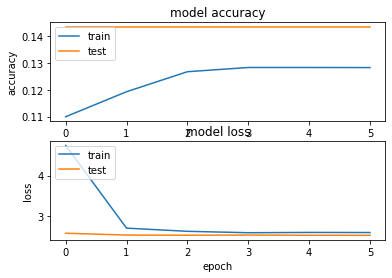

In [72]:
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 